In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# load the sales data set
sales_data = pd.read_csv('../../../../Data/SalesData.csv')
sales_data.head()

sales_data = sales_data[sales_data['Category'] == 'Needles'] 


pharmacy_onehot = pd.get_dummies(sales_data['Pharmacy'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded2 = pd.concat([sales_data, pharmacy_onehot], axis=1)

product_onehot = pd.get_dummies(sales_data['Product'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded3 = pd.concat([sales_data_encoded2, product_onehot], axis=1)

product_onehot = pd.get_dummies(sales_data['Location'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded = pd.concat([sales_data_encoded3, product_onehot], axis=1)

sales_data_encoded


,Date,Month,Quarter,Year,Qty,Product,Category,Pharmacy,Location,Pharmacy 10,...,"Brazil, USA, Blank, IE, Zimbabwe, Zurich",Ireland & Northern Ireland,London,"NorthEast, Midlands",NorthWest,Outside London M25,Outside London the rest,"Scotland, Newcastle",SouthEast,SouthWest
14,1-12-2015,12,4,2015,1,Mesotherapy Needles,Needles,Pharmacy 2,Outside London M25,0,...,0,0,0,0,0,1,0,0,0,0
39,1-1-2016,1,1,2016,1,Mesotherapy Needles,Needles,Pharmacy 2,NorthWest,0,...,0,0,0,0,1,0,0,0,0,0
40,1-1-2016,1,1,2016,1,Mesotherapy Needles,Needles,Pharmacy 2,Outside London M25,0,...,0,0,0,0,0,1,0,0,0,0
41,1-1-2016,1,1,2016,1,Mesotherapy Needles,Needles,Pharmacy 2,Outside London M25,0,...,0,0,0,0,0,1,0,0,0,0
79,1-2-2016,2,1,2016,1,Mesotherapy Needles,Needles,Pharmacy 2,"Scotland, Newcastle",0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68074,1-3-2022,3,1,2022,1,Skin Booster Needles,Needles,Pharmacy 3,SouthEast,0,...,0,0,0,0,0,0,0,0,1,0
68087,1-3-2022,3,1,2022,6,Skin Booster Needles,Needles,Pharmacy 10,Outside London the rest,1,...,0,0,0,0,0,0,1,0,0,0
68092,1-3-2022,3,1,2022,1,Skin Booster Needles,Needles,Pharmacy 10,Ireland & Northern Ireland,1,...,0,1,0,0,0,0,0,0,0,0
68130,1-3-2022,3,1,2022,1,Mesotherapy Needles,Needles,Pharmacy 10,Ireland & Northern Ireland,1,...,0,1,0,0,0,0,0,0,0,0


In [2]:
list(sales_data_encoded.columns)

['Date',
 'Month',
 'Quarter',
 'Year',
 'Qty',
 'Product',
 'Category',
 'Pharmacy',
 'Location',
 'Pharmacy 10',
 'Pharmacy 2',
 'Pharmacy 3',
 'Pharmacy 4',
 'Pharmacy 5',
 'Pharmacy 9',
 'Mesotherapy Needles',
 'Skin Booster Needles',
 'Brazil, USA, Blank, IE, Zimbabwe, Zurich',
 'Ireland & Northern Ireland',
 'London',
 'NorthEast, Midlands',
 'NorthWest',
 'Outside London M25',
 'Outside London the rest',
 'Scotland, Newcastle',
 'SouthEast',
 'SouthWest']

In [3]:
# group the data by date and sum the quantities and category columns
sales_data_grouped = sales_data_encoded.groupby('Date').agg({
    'Qty': 'sum',
    'Pharmacy 2' : 'sum',
    'Pharmacy 3' : 'sum',
    'Pharmacy 4' : 'sum',
    'Pharmacy 5' : 'sum',
    'Pharmacy 9' : 'sum',
    'Pharmacy 10' : 'sum',
    'Mesotherapy Needles' : 'sum',
    'Skin Booster Needles' : 'sum',
    'Brazil, USA, Blank, IE, Zimbabwe, Zurich' : 'sum',
    'Ireland & Northern Ireland' : 'sum',
    'London' : 'sum',
    'NorthEast, Midlands' : 'sum',
    'NorthWest' : 'sum',
    'Outside London M25' : 'sum',
    'Outside London the rest' : 'sum',
    'Scotland, Newcastle' : 'sum',
    'SouthEast' : 'sum',
    'SouthWest' : 'sum'
    					
})

# reset the index to make date a column again
sales_data_grouped = sales_data_grouped.reset_index()

# create lag features
sales_data_lagged = sales_data_grouped.copy()
for i in range(1, 8):
    sales_data_lagged[f'Qty_lag_{i}'] = sales_data_lagged['Qty'].shift(i)

# print(sales_data_lagged)

# remove rows with missing values
sales_data_lagged.dropna(inplace=True)

sales_data_lagged['Date'] = pd.to_datetime(sales_data_lagged['Date'], format='%d-%m-%Y')

from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(sales_data_lagged.loc[:,sales_data_lagged.columns!='Qty'], sales_data_lagged.loc[:,['Date', 'Qty']], test_size=0.2, random_state=42)
X = sales_data_lagged.loc[(sales_data_lagged['Date'] < '2020-04-01')]
y = sales_data_lagged.loc[(sales_data_lagged['Date'] >= '2020-04-01') & (sales_data_lagged['Date']<= '2021-04-01')]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X.loc[:,X.columns!='Qty']
X_test = y.loc[:,y.columns!='Qty']
y_train = X.loc[:,X.columns=='Qty']
y_test = y.loc[:,y.columns=='Qty']



In [4]:
y

,Date,Qty,Pharmacy 2,Pharmacy 3,Pharmacy 4,Pharmacy 5,Pharmacy 9,Pharmacy 10,Mesotherapy Needles,Skin Booster Needles,...,"Scotland, Newcastle",SouthEast,SouthWest,Qty_lag_1,Qty_lag_2,Qty_lag_3,Qty_lag_4,Qty_lag_5,Qty_lag_6,Qty_lag_7
10,2020-10-01,45,2,7,0,0,7,0,3,13,...,2,2,0,4.0,1.0,1.0,2.0,6.0,6.0,20.0
16,2020-11-01,17,2,3,0,0,4,2,7,4,...,1,0,0,65.0,14.0,2.0,2.0,54.0,45.0,4.0
22,2020-12-01,36,4,4,0,0,4,2,6,8,...,1,1,2,3.0,25.0,2.0,1.0,29.0,17.0,65.0
28,2021-02-01,9,3,1,0,0,0,1,4,1,...,0,1,0,43.0,7.0,2.0,1.0,8.0,36.0,3.0
33,2021-03-01,32,3,9,0,0,1,0,4,9,...,1,3,0,32.0,1.0,2.0,9.0,9.0,43.0,7.0
38,2020-04-01,1,1,0,0,0,0,0,1,0,...,0,0,0,3.0,1.0,5.0,17.0,32.0,32.0,1.0
39,2021-04-01,41,4,6,0,1,6,0,9,8,...,0,4,3,1.0,3.0,1.0,5.0,17.0,32.0,32.0
43,2020-05-01,28,1,3,0,0,0,0,1,3,...,0,0,0,2.0,3.0,2.0,41.0,1.0,3.0,1.0
49,2020-06-01,8,2,2,0,0,0,0,2,2,...,0,1,0,4.0,2.0,1.0,1.0,59.0,28.0,2.0
53,2020-07-01,17,4,4,0,0,0,0,4,4,...,0,1,0,5.0,3.0,118.0,8.0,4.0,2.0,1.0


In [5]:
# train a random forest model

# model = RandomForestRegressor(n_estimators=100, max_depth=5)
# model.fit(train_data.iloc[:, 2:], train_data['Qty'])

criterion = ['squared_error', 'friedman_mse', 'poisson']
max_depth = [5, 10]
min_samples_leaf = [1, 2]
max_features = ['log2', 'sqrt']

random_grid_rfr = {
    'criterion' : criterion,
    'max_depth' : max_depth,
    'min_samples_leaf' : min_samples_leaf,
    'max_features' : max_features
}

rfr = RandomForestRegressor()
rfr_random = RandomizedSearchCV(
    estimator=rfr,
    param_distributions=random_grid_rfr,
    n_iter=10,
    cv=5,
    verbose=5,
    random_state=0
)

In [6]:
rfr_random.fit(X_train.iloc[:, 2:], y_train['Qty'])


# make predictions for the test data
predictions = rfr_random.predict(X_test.iloc[:, 2:])

# calculate the root mean squared error (RMSE) of the predictions
rmse = ((predictions - y_test['Qty']) ** 2).mean() ** 0.5
print('RMSE:', rmse)

print(predictions)



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2;, score=0.440 total time=   0.1s
[CV 2/5] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2;, score=0.557 total time=   0.1s
[CV 3/5] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2;, score=0.899 total time=   0.1s
[CV 4/5] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2;, score=-5.327 total time=   0.1s
[CV 5/5] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2;, score=0.799 total time=   0.1s
[CV 1/5] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1;, score=0.590 total time=   0.0s
[CV 2/5] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1;, score=0.613 total time=   0.1s
[CV 3/5] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1;, s

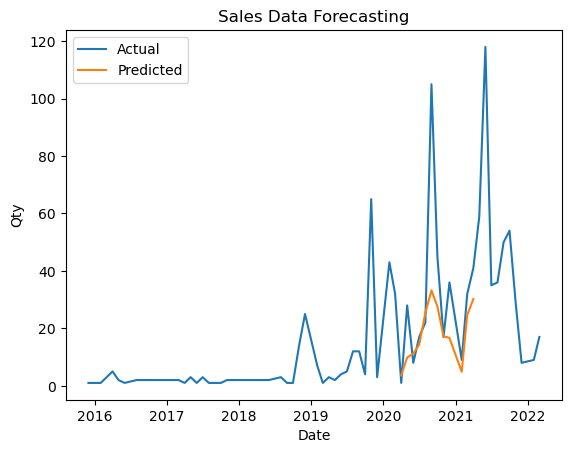

In [7]:

sales_data_lagged['predicted_quantity'] = pd.Series(predictions, index=y_test.index)
sales_data_lagged= sales_data_lagged.sort_values(by=['Date'])

# plot the actual and predicted quantities against date
plt.plot(sales_data_lagged['Date'], sales_data_lagged['Qty'], label='Actual')
plt.plot(sales_data_lagged['Date'], sales_data_lagged['predicted_quantity'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Sales Data Forecasting')
plt.legend()
plt.show()

In [8]:
rfr_random.best_params_

{'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 10,
 'criterion': 'poisson'}

[array(['2020-10-01T00:00:00.000000000', '2020-11-01T00:00:00.000000000',
       '2020-12-01T00:00:00.000000000', '2021-02-01T00:00:00.000000000',
       '2021-03-01T00:00:00.000000000', '2020-04-01T00:00:00.000000000',
       '2021-04-01T00:00:00.000000000', '2020-05-01T00:00:00.000000000',
       '2020-06-01T00:00:00.000000000', '2020-07-01T00:00:00.000000000',
       '2020-08-01T00:00:00.000000000', '2020-09-01T00:00:00.000000000'],
      dtype='datetime64[ns]'), array([ 45,  17,  36,   9,  32,   1,  41,  28,   8,  17,  22, 105],
      dtype=int64), array([27.62 , 17.27 , 16.68 ,  4.89 , 24.63 ,  3.655, 30.23 ,  9.84 ,
       11.21 , 14.35 , 25.38 , 33.21 ])]


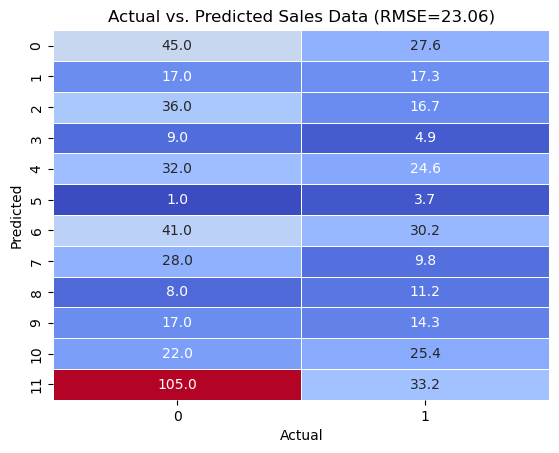

In [9]:
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
import math

matrix_data = np.column_stack((y_test['Qty'].values, predictions))

#print((test_data['Qty'].values, predictions))
print([X_test['Date'].values, y_test['Qty'].values, predictions])

# calculate the mean squared error
mse = mean_squared_error(y_test['Qty'], predictions)
rmse = math.sqrt(mse)

# plot the matrix using seaborn's heatmap function
sns.heatmap(matrix_data, annot=True, fmt='.1f', cmap='coolwarm', linewidths=.5, cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs. Predicted Sales Data (RMSE={rmse:.2f})')
plt.show()